Importing Libraries

In [5]:
import numpy as np
import pandas as pd
import os, time
import pickle, gzip

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
color = sns.color_palette()

from sklearn import preprocessing as pp
from scipy.stats import pearsonr
from numpy.testing import assert_array_almost_equal
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import lightgbm as lgb

In [6]:
curr_path = os.getcwd()
f = gzip.open(curr_path + '/mnist.pkl.gz', 'rb')
train_set, validation_set, test_set = pickle.load(f, encoding='latin1')
f.close()

X_train, y_train = train_set[0], train_set[1]
X_val, y_val = validation_set[0], validation_set[1]
X_test, y_test = test_set[0], test_set[1]

Training set: (50000, 784) (50000,)
Validation set: (10000, 784) (10000,)
Test set: (10000, 784) (10000,)


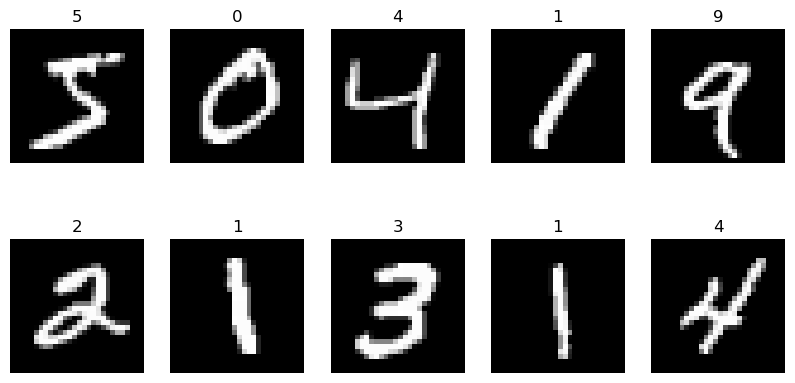

In [7]:
print('Training set:', X_train.shape, y_train.shape)
print('Validation set:', X_val.shape, y_val.shape)
print('Test set:', X_test.shape, y_test.shape)

# plot the first 10 images
fig, ax = plt.subplots(2, 5, figsize=(10, 5))
for i, j in enumerate([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]):
    ax[i//5, i%5].imshow(X_train[j].reshape((28, 28)), cmap='gray')
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_title(y_train[j])
plt.show()

In [8]:
train_index = range(0, len(X_train))
val_index = range(len(X_train), len(X_train)+len(X_val))
test_index = range(len(X_train)+len(X_val), len(X_train)+len(X_val)+len(X_test))

X_train = pd.DataFrame(data=X_train, index=train_index)
y_train = pd.Series(data=y_train, index=train_index)
X_val = pd.DataFrame(data=X_val, index=val_index)
y_val = pd.Series(data=y_val, index=val_index)

X_test = pd.DataFrame(data=X_test, index=test_index)
y_test = pd.Series(data=y_test, index=test_index)

In [9]:
X_train.describe()

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
count,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,...,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.0,50000.0,50000.0,50000.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000739,0.000354,0.000204,0.000090,0.000071,0.000009,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.022778,0.015422,0.012079,0.007217,0.007181,0.001483,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.992188,0.992188,0.988281,0.988281,0.992188,0.242188,0.0,0.0,0.0,0.0


In [10]:
y_train.head()

0    5
1    0
2    4
3    1
4    9
dtype: int64

In [11]:
def view_digit(example, label=None):
    if label is not None:
        print("true label:", label)
    plt.imshow(example.values.reshape((28, 28)), cmap='gray')
    plt.axis('off')
    plt.show()

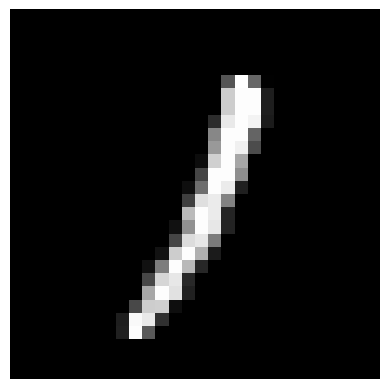

In [12]:
view_digit(X_train.loc[99])

## Dimenstionality Reduction

In [13]:
from sklearn.decomposition import PCA

n_components = 784
whiten = False
random_state = 2018

pca = PCA(n_components=n_components, whiten=whiten, random_state=random_state)


In [14]:
X_train_PCA = pca.fit_transform(X_train)
X_train_PCA = pd.DataFrame(data=X_train_PCA, index=train_index)

In [15]:
print("The variance explained by all 784 PC is: ", pca.explained_variance_ratio_.sum())

The variance explained by all 784 PC is:  0.99999994


In [16]:
importance = pd.DataFrame(data=pca.explained_variance_ratio_)
importance = importance.T

print(importance)

        0         1         2         3         4         5         6    \
0  0.097444  0.070598  0.062161  0.053795  0.048581  0.043196  0.032776   

        7         8         9    ...  774  775  776  777  778  779  780  781  \
0  0.028864  0.027688  0.023659  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

   782  783  
0  0.0  0.0  

[1 rows x 784 columns]


In [17]:
print("The variance explained by the first 100 PC is: ", importance.loc[:, :99].sum(axis=1).values)

The variance explained by the first 100 PC is:  [0.9146585]


          0         1  0
0  0.461509  1.246865  5
1  3.921650  1.251652  0
2 -0.203711 -1.547883  4
3 -3.148447  2.296119  1
4 -1.442680 -2.872079  9


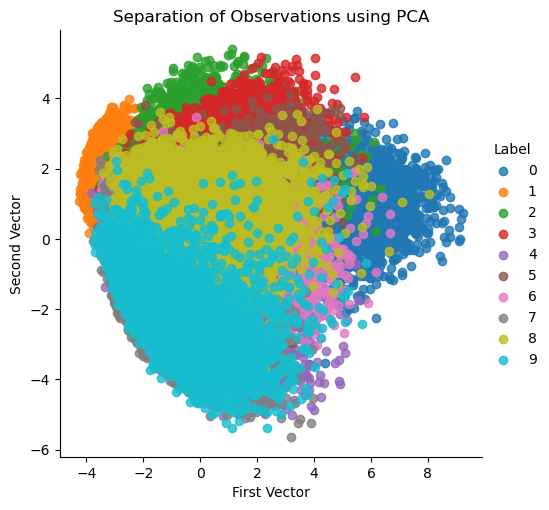

In [18]:
def scatter_plot(X, y, title):
    temp_df = pd.DataFrame(data=X.loc[:, 0:1], index=X.index)
    temp_df = pd.concat((temp_df,y), axis=1, join="inner")
    print(temp_df.head())
    temp_df.columns = ["First Vector","Second Vector","Label"]
    sns.lmplot(x='First Vector', y='Second Vector', data=temp_df, hue='Label', fit_reg=False)
    ax = plt.gca()
    ax.set_title('Separation of Observations using ' + title)

scatter_plot(X_train_PCA, y_train, 'PCA')

          0         1  0
0  0.456938  1.234728  5
1  3.882746  1.239761  0
2 -0.201423 -1.532631  4
3 -3.117264  2.273349  1
4 -1.428181 -2.843882  9


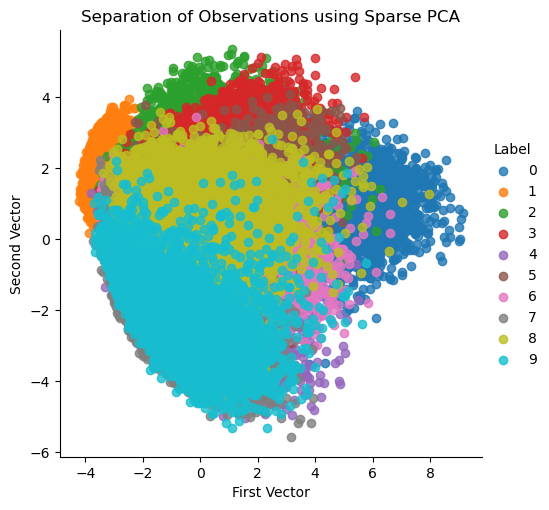

In [39]:
# Sparse PCA

from sklearn.decomposition import SparsePCA

n_components = 100
alpha = 0.0001
random_state = 2018
n_jobs = -1

sparse_pca = SparsePCA(n_components=n_components, alpha=alpha, random_state=random_state, n_jobs=n_jobs)

X_train_sparse_PCA = sparse_pca.fit_transform(X_train)
X_train_sparse_PCA = pd.DataFrame(data=X_train_sparse_PCA, index=train_index)

scatter_plot(X_train_sparse_PCA, y_train, 'Sparse PCA')

          0         1  0
0  6.464405  0.217987  5
1  6.845079 -3.564428  0
2  3.130552 -1.369391  4
3  4.107910  2.928722  1
4  5.862704  1.823511  9


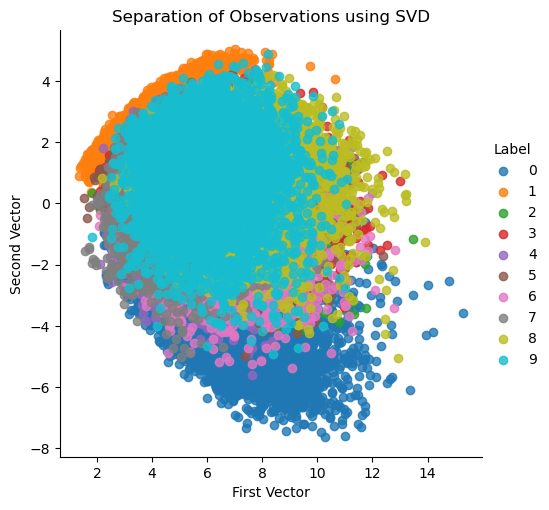

In [13]:
# Single Value Decomposition

from sklearn.decomposition import TruncatedSVD

n_components = 200
algorithm = 'randomized'
n_iter = 5
random_state = 2018

svd = TruncatedSVD(n_components=n_components, algorithm=algorithm, n_iter=n_iter, random_state=random_state)

X_train_svd = svd.fit_transform(X_train)
X_train_svd = pd.DataFrame(data=X_train_svd, index=train_index)

scatter_plot(X_train_svd, y_train, 'SVD')

## Random Projection

          0         1  0
0  0.296114  0.292814  5
1  0.805610  0.492694  0
2  0.287017 -0.233497  4
3 -0.534715  0.122500  1
4  0.040014  0.155505  9


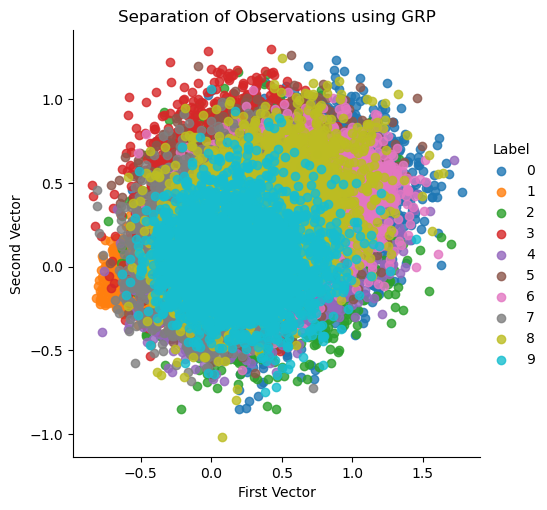

In [41]:
# Gaussian Random Projection

from sklearn.random_projection import GaussianRandomProjection

n_components = 'auto'
eps = 0.5
random_state = 2018

GRP = GaussianRandomProjection(n_components=n_components, eps=eps, random_state=random_state)

X_train_GRP = GRP.fit_transform(X_train)
X_train_GRP = pd.DataFrame(data=X_train_GRP, index=train_index)

scatter_plot(X_train_GRP, y_train, 'GRP')

          0         1  0
0 -0.185998  0.023590  5
1 -0.678667  0.023590  0
2  0.107062 -0.152428  4
3  0.377441 -0.198701  1
4 -0.356573 -0.421899  9


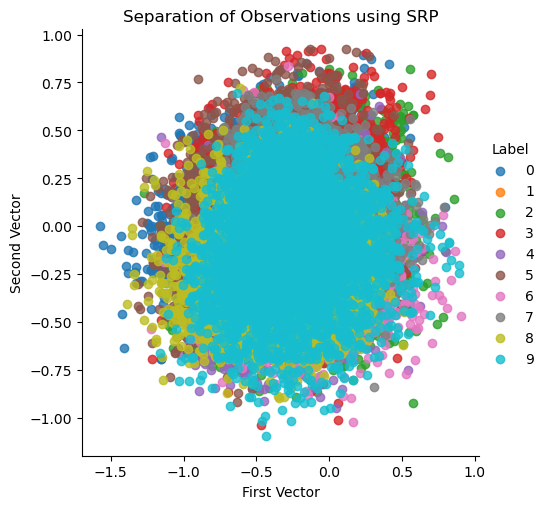

In [42]:
# Sparse Random Projection

from sklearn.random_projection import SparseRandomProjection

n_components = 'auto'
density = 'auto'
eps = 0.5
dense_output = False
random_state = 2018

SRP = SparseRandomProjection(n_components=n_components, density=density, eps=eps, dense_output=dense_output, random_state=random_state)

X_train_SRP = SRP.fit_transform(X_train)
X_train_SRP = pd.DataFrame(data=X_train_SRP, index=train_index)

scatter_plot(X_train_SRP, y_train, 'SRP')

## Isomap

           0          1  0
0   2.235491  -8.412565  5
1  30.420765   8.812830  0
2 -11.197481  20.031890  4
3  -7.680681 -16.298225  1
4 -16.162058   8.110874  9


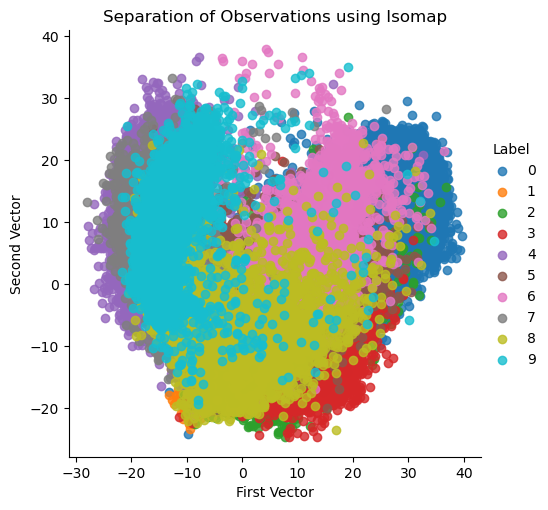

In [15]:
# IsoMap

from sklearn.manifold import Isomap

n_neighbors = 5
n_components = 2
n_jobs = 4

iso = Isomap(n_neighbors=n_neighbors, n_components=n_components, n_jobs=n_jobs)

iso.fit(X_train.loc[0:5000, :])
X_train_iso = iso.transform(X_train)
X_train_iso = pd.DataFrame(data=X_train_iso, index=train_index)

scatter_plot(X_train_iso, y_train, 'Isomap')

## Multidimensiona Scaling

          0         1  0
0  5.325204 -0.352233  5
1  3.394096 -7.016880  0
2 -7.720181  0.608485  4
3  2.520855  5.971553  1
4 -4.661012  0.477704  9


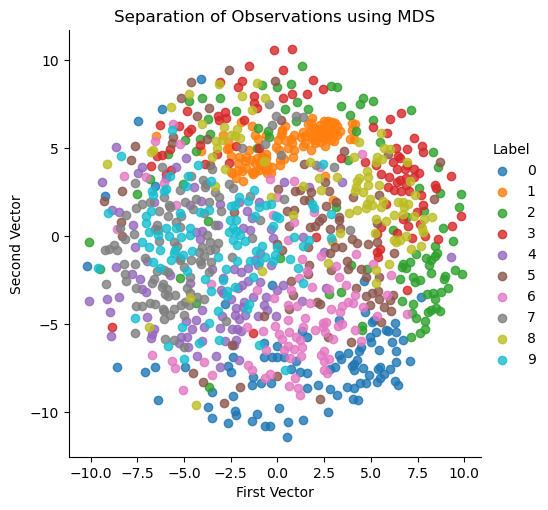

In [18]:
# Multi-Dimensional Scaling

from sklearn.manifold import MDS

n_components = 2
n_init = 12
max_iter = 1200
metric = True
n_jobs = 4
random_state = 2018

mds = MDS(n_components=n_components, n_init=n_init, max_iter=max_iter, metric=metric, n_jobs=n_jobs, random_state=random_state)

X_train_mds = mds.fit_transform(X_train.loc[0:1000, :])
X_train_mds = pd.DataFrame(data=X_train_mds, index=train_index[0:1001])

scatter_plot(X_train_mds, y_train, 'MDS')

## Locally Linear Embedding (LLE)

          0         1  0
0 -0.002119  0.002279  5
1 -0.038639  0.000455  0
2  0.004908 -0.019997  4
3  0.016444  0.032776  1
4  0.010456 -0.014570  9


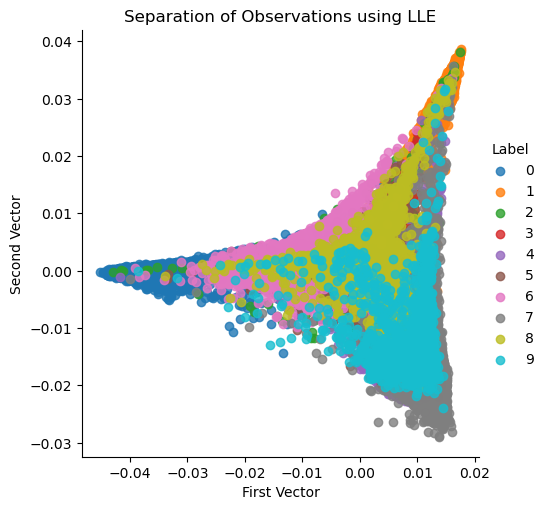

In [21]:
# Apply LLE

from sklearn.manifold import LocallyLinearEmbedding

n_neighbors = 10
n_components = 2
method = 'modified'
n_jobs = 4
random_state = 2018

lle = LocallyLinearEmbedding(n_neighbors=n_neighbors, n_components=n_components, method=method, n_jobs=n_jobs, random_state=random_state)

lle.fit(X_train.loc[0:5000, :])
X_train_lle = lle.transform(X_train)
X_train_lle = pd.DataFrame(data=X_train_lle, index=train_index)

scatter_plot(X_train_lle, y_train, 'LLE')

## t-Distributed Stochastic Neighbour Embedding

           0          1  0
0  20.158089  -5.787548  5
1  73.016273 -12.297735  0
2 -24.123516 -49.176292  4
3 -33.916557  55.446648  1
4 -26.749954 -13.886337  9


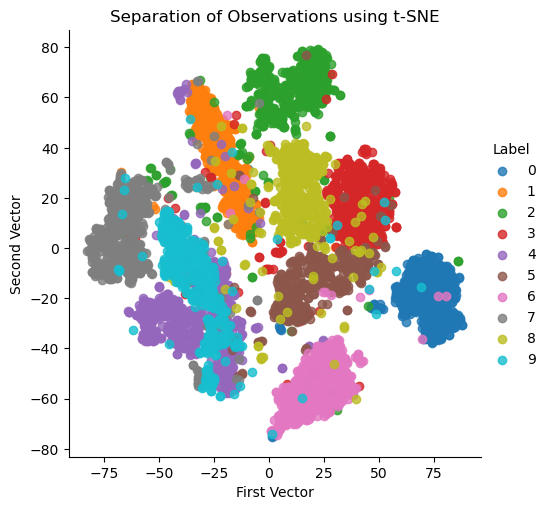

In [23]:
# t-SNE

from sklearn.manifold import TSNE

n_components = 2
learning_rate = 300
perplexity = 30
early_exaggeration = 12
init = 'random'
random_state = 2018

tSNE = TSNE(n_components=n_components, learning_rate=learning_rate, perplexity=perplexity, early_exaggeration=early_exaggeration, init=init, random_state=random_state)

X_train_tSNE = tSNE.fit_transform(X_train.loc[0:5000, :])
X_train_tSNE = pd.DataFrame(data=X_train_tSNE, index=train_index[0:5001])

scatter_plot(X_train_tSNE, y_train, 't-SNE')